###  Gaussian Classifier

Apply the MVG model to the project data. Split the dataset in model training and validation subsets
(important: use the same splits for all models, including those presented in other laboratories), train the
model parameters on the model training portion of the dataset and compute LLRs

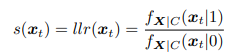

In [378]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg


In [379]:
def vcol(x):
    return x.reshape((x.size, 1))

In [380]:
def vrow(x):
    return x.reshape((1, x.size))

In [381]:
def load(filename):
    DList=[]
    lablesList=[]
    #La classe puo cambiare
    with open(filename) as f:
        for line in f:
            line=line.strip()
            try:
                fields=line.split(',')[0:-1] # prendo tutti i campi tranne l'ultimo ovvero l etichetta
                fields=vcol(np.array([float(x) for x in fields]))
                DList.append(fields)
                label=line.split(',')[-1].strip()
                lablesList.append(label)
            except:
                pass
    return np.hstack(DList),np.array(lablesList,dtype=np.int32)
            

In [382]:
#prima di essre processati i dati devono essere spostati nell origini, ovvero avere media 0
def compute_mu_C(X):
    "Calcolo la media e la matrice di covarianza dei dati x"
    mu = vcol(X.mean(1))

    C = ((X-mu)@(X-mu).T)/float(X.shape[1])
    return mu, C

In [383]:
def logpdf_GAU_ND(X, mu, C):
    """
    Compute the log-density of a multivariate Gaussian distribution for multiple samples.
    X is a 2D numpy array where each column is a sample, mu is the mean vector, and C is the covariance matrix.
    Returns a 1D numpy array of log-density values for each sample.
    """
    P=np.linalg.inv(C) #inverse of covariance matrix (Precision matrix)
    return -0.5*X.shape[0]*np.log(2*np.pi)-0.5*np.linalg.slogdet(C)[1]-0.5* ((X-mu) * (P @ (X-mu))).sum(0) 


In [384]:
def split_db_2to1(D, L, seed=0):
    nTrain = int(D.shape[1]*2.0/3.0)
    np.random.seed(seed)
    idx = np.random.permutation(D.shape[1])
    idxTrain = idx[0:nTrain]
    idxTest = idx[nTrain:]
    DTR = D[:, idxTrain]
    DVAL = D[:, idxTest]
    LTR = L[idxTrain]
    LVAL = L[idxTest]
    return (DTR, LTR), (DVAL, LVAL)

In [385]:
D,lables=load('trainData.txt')
(DTR,LTR), (DVAL,LVAL)=split_db_2to1(D,lables)


(i.e., with class True, label 1 on top of the ratio) for the validation subset. Obtain predictions from
LLRs assuming uniform class priors P(C = 1) = P(C = 0) = 1/2. Compute the corresponding error
rate (suggestion: in the next laboratories we will modify the way we compute predictions from LLRs,
we therefore recommend that you keep separated the functions that compute LLRs, those that compute
predictions from LLRs and those that compute error rate from predictions).


### MVG Model

In [386]:
def Gau_MVG_ML_estimation(D,L):
    labelSet=set(L)
    hParams = {}
    for label in labelSet:
        DLabel=D[:,L==label]
        mu, C = compute_mu_C(DLabel)
        hParams[label] = (mu, C)
    return hParams


### Tied Model

In [387]:
def Gau_Tied_ML_estimation(D,L):
    labelSet=set(L)
    hParams={}
    hMeans={}
    CGlobal=0
    for label in labelSet:
        DLabel=D[:,L==label]
        mu, C_class = compute_mu_C(DLabel)
        hMeans[label] = mu
        CGlobal += C_class*DLabel.shape[1]
    CGlobal=CGlobal/D.shape[1]
    for label in labelSet:
        hParams[label] = (hMeans[label], CGlobal)
    return hParams

In [388]:
def compute_llr_binary(D,hParams):
    """Compute log-likelihood ratio (LLR) for binary classification."""
    llr = logpdf_GAU_ND(D, hParams[1][0], hParams[1][1]) - logpdf_GAU_ND(D, hParams[0][0], hParams[0][1])
    return llr

In [389]:
def compute_prediction_from_llr_binary(llr,trashold=0):
    """Compute binary prediction from log-likelihood ratio (LLR)."""
    predictions=np.zeros(llr.size,dtype=np.int32)
    predictions[llr>=trashold]=1
    predictions[llr<trashold]=0
    print('Number of errors:',np.sum(predictions!=LVAL)," out of ",LVAL.size,"samples")
    return predictions


In [390]:
def compute_error_rate(predictions, labels):
    """Compute error rate."""
    return (predictions != labels).sum() / float(labels.size) * 100

Apply now the tied Gaussian model, and compare the results with MVG and LDA. Which model seems
to perform better?


In [391]:
#MVG model
hParams_mvg = Gau_MVG_ML_estimation(DTR, LTR)
llr_mvg = compute_llr_binary(DVAL, hParams_mvg)
predictions_mvg = compute_prediction_from_llr_binary(llr_mvg)#trashold=0
error_rate_mvg = compute_error_rate(predictions_mvg, LVAL)
print("Error rate MVG: ", error_rate_mvg)  
print("Accuracy MVG: ", 100 - error_rate_mvg) 
print("")
#Tied model
hParams_tied = Gau_Tied_ML_estimation(DTR, LTR)
llr_tied = compute_llr_binary(DVAL, hParams_tied)
predictions_tied = compute_prediction_from_llr_binary(llr_tied)#trashold=0
error_rate_tied = compute_error_rate(predictions_tied, LVAL)
print("Error rate Tied: ", error_rate_tied)
print("Accuracy Tied: ", 100 - error_rate_tied)    


Number of errors: 140  out of  2000 samples
Error rate MVG:  7.000000000000001
Accuracy MVG:  93.0

Number of errors: 186  out of  2000 samples
Error rate Tied:  9.3
Accuracy Tied:  90.7


Finally, test the Naive Bayes Gaussian model. How does it compare with the previous two?

### Naive Bayes

In [392]:
def Gau_NaiveBayes_ML_estimation(D,L):
    labelSet=set(L)
    hParams = {}
    for label in labelSet:
        DLabel=D[:,L==label]
        mu, C = compute_mu_C(DLabel)
        C = C*np.eye(D.shape[0]) #diagonal covariance matrix
        hParams[label] = (mu, C)
    return hParams

In [393]:
#Naive Bayes model
hParams_naive = Gau_NaiveBayes_ML_estimation(DTR, LTR)
llr_naive = compute_llr_binary(DVAL, hParams_naive)
predictions_naive = compute_prediction_from_llr_binary(llr_naive)#trashold=0
error_rate_naive = compute_error_rate(predictions_naive, LVAL)
print("Error rate Naive: ", error_rate_naive)
print("Accuracy Naive: ", 100 - error_rate_naive)

Number of errors: 144  out of  2000 samples
Error rate Naive:  7.199999999999999
Accuracy Naive:  92.8


The MVG (Multivariate Gaussian) model resulted in 140 errors out of 2000 samples, giving an error rate of 7.0% and an accuracy of 93.0%.

The Tied Gaussian model resulted in 186 errors out of 2000 samples, with an error rate of 9.3% and accuracy of 90.7%.

The LDA model showed the same performance as the Tied Gaussian model with an error rate of 9.3% and accuracy of 90.7%.(Part 2)

The Naive Bayes Gaussian model resulted in 144 errors out of 2000 samples, with an error rate of 7.2% and accuracy of 92.8%.

Comparing these models:

1. The MVG model performs the best with 93.0% accuracy, closely followed by the Naive Bayes model with 92.8% accuracy.

2. Both the Tied Gaussian and LDA models perform identically with 90.7% accuracy. This is expected since these models are mathematically equivalent when using the same threshold - both assume a common covariance matrix for all classes.

3. The superior performance of the MVG model suggests that the classes in your dataset have different covariance structures, which the MVG model successfully captures by estimating separate covariance matrices for each class.

4. The Naive Bayes model performs remarkably well despite its simplified assumption of feature independence. This suggests that while there might be some correlation between features, modeling each feature independently still captures most of the discriminative information in the data.



### Covariance Matrix Analysis
Let’s now analyze the results in light of the characteristics of the features that we observed in previous
laboratories. Start by printing the covariance matrix of each class (you can extract this from the MVG
model parameters). The covariance matrices contain, on the diagonal, the variances for the different
features, whereas the elements outside of the diagonal are the feature co-variances. For each class,
compare the covariance of different feature pairs with the respective variances. What do you observe?
Are co-variance values large or small compared to variances? To better visualize the strength of covariances with respect to variances we can compute, for a pair of features i, j, the Pearson correlation
coefficient, defined as:

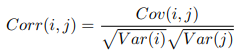



Compute the correlation matrices for the two classes. What can you conclude on the features? Are the
features strongly or weakly correlated? How is this related to the Naive Bayes results?

In [394]:
def compute_correlation_matrix(C):
    """Compute the correlation matrix from the covariance matrix."""
    Corr = C / ( vcol(C.diagonal()**0.5) * vrow(C.diagonal()**0.5) )
    return Corr

In [395]:
C = hParams_mvg[0][1]  # Covariance matrix for class 0
C1 = hParams_mvg[1][1]  # Covariance matrix for class 1
    
print("Covariance matrix for class 0:")
print(C0)
print("\nCorrelation matrix for class 0:")
print(compute_correlation_matrix(C0))
print("\nCovariance matrix for class 1:")
print(C1)
print("\nCorrelation matrix for class 1:")
print(compute_correlation_matrix(C1))

Covariance matrix for class 0:
[[ 6.00956506e-01  5.15866517e-05  1.90589145e-02  1.92529876e-02
   1.28039402e-02 -1.34721598e-02]
 [ 5.15866517e-05  1.44722543e+00 -1.61340110e-02 -1.58561474e-02
  -2.64529141e-02  2.29139833e-02]
 [ 1.90589145e-02 -1.61340110e-02  5.65348901e-01 -1.84344435e-03
  -6.91446277e-03  1.68928322e-02]
 [ 1.92529876e-02 -1.58561474e-02 -1.84344435e-03  5.41615202e-01
   5.25171375e-03  1.35717775e-02]
 [ 1.28039402e-02 -2.64529141e-02 -6.91446277e-03  5.25171375e-03
   6.96067641e-01  1.58438399e-02]
 [-1.34721598e-02  2.29139833e-02  1.68928322e-02  1.35717775e-02
   1.58438399e-02  6.86519710e-01]]

Correlation matrix for class 0:
[[ 1.00000000e+00  5.53156127e-05  3.26977873e-02  3.37466904e-02
   1.97968638e-02 -2.09743833e-02]
 [ 5.53156127e-05  1.00000000e+00 -1.78367604e-02 -1.79095288e-02
  -2.63560127e-02  2.29882544e-02]
 [ 3.26977873e-02 -1.78367604e-02  1.00000000e+00 -3.33139656e-03
  -1.10223563e-02  2.71155043e-02]
 [ 3.37466904e-02 -1.79095

Looking at the correlation matrices, we can observe that all off-diagonal elements have very small values, with most correlation coefficients falling between -0.05 and 0.05. The largest correlation coefficient is approximately 0.049 (between features 3 and 4 in class 1).

These small correlation values indicate that the features in your dataset are very weakly correlated. In fact, they are nearly uncorrelated, as correlation coefficients close to zero suggest minimal linear relationship between features.

This weak correlation between features explains why the Naive Bayes model performs almost as well as the full MVG model (92.8% vs 93.0% accuracy). The Naive Bayes model makes the assumption that features are independent within each class, which is represented by diagonal covariance matrices. When features are truly nearly independent (as indicated by the correlation matrices), this assumption is very close to reality, and the Naive Bayes model suffers minimal performance loss compared to the full model.

The MVG model still performs slightly better (by 0.2%) because it can capture even these weak correlations between features, which apparently provide some small additional discriminative information. However, the difference is minimal, suggesting that the independence assumption is a reasonable simplification for this dataset.

This also explains why the Naive Bayes model significantly outperforms the Tied Gaussian model (92.8% vs 90.7%). The Naive Bayes model correctly captures the class-specific variances while making a reasonable assumption about feature independence, whereas the Tied model incorrectly assumes that both classes share the same covariance structure.

In conclusion, the features in your dataset exhibit very weak correlation, which aligns perfectly with the strong performance of the Naive Bayes model. This suggests that for this classification task, the diagonal covariance assumption is appropriate, making Naive Bayes an efficient model choice that provides a good balance between performance and computational simplicity.

The Gaussian model assumes that features can be jointly modeled by Gaussian distributions. The goodness of the model is therefore strongly affected by the accuracy of this assumption. Although visualizing
6-dimensional distributions is unfeasible, we can analyze how well the assumption holds for single (or
pairs) of features. In Part 3 we separately fitted a Gaussian density over each feature for each
class. This corresponds to the Naive Bayes model. What can you conclude on the goodness of the
Gaussian assumption? Is it accurate for all the 6 features? Are there features for which the assumptions
do not look good?

As observed in Part 3, Features 4 and 5 for both classes deviate significantly from Gaussian distribution assumptions. The multimodal nature of their distributions, particularly the bimodal pattern in the True Fingerprint class, fundamentally contradicts the unimodal character expected in Gaussian models.


To analyze if indeed the last set of features negatively affects our classifier because of poor modeling
assumptions, we can try repeating the classification using only feature 1 to 4 (i.e., discarding the last 2
features). Repeat the analysis for the three models. What do you obtain? What can we conclude on
discarding the last two features? Despite the inaccuracy of the assumption for these two features, are
the Gaussian models still able to extract some useful information to improve classification accuracy?


In [396]:
#Fetures 0 to 3
D,lables=load('trainData.txt')
D=D[0:4,:]
(DTR,LTR), (DVAL,LVAL)=split_db_2to1(D,lables)

#MVG model
hParams_mvg = Gau_MVG_ML_estimation(DTR, LTR)
llr_mvg = compute_llr_binary(DVAL, hParams_mvg)
predictions_mvg = compute_prediction_from_llr_binary(llr_mvg)#trashold=0
error_rate_mvg = compute_error_rate(predictions_mvg, LVAL)
print("Error rate MVG: ", error_rate_mvg)  
print("Accuracy MVG: ", 100 - error_rate_mvg) 
print("")
#Tied model
hParams_tied = Gau_Tied_ML_estimation(DTR, LTR)
llr_tied = compute_llr_binary(DVAL, hParams_tied)
predictions_tied = compute_prediction_from_llr_binary(llr_tied)#trashold=0
error_rate_tied = compute_error_rate(predictions_tied, LVAL)
print("Error rate Tied: ", error_rate_tied)
print("Accuracy Tied: ", 100 - error_rate_tied)
print("")    
#Naive Bayes model
hParams_naive = Gau_NaiveBayes_ML_estimation(DTR, LTR)
llr_naive = compute_llr_binary(DVAL, hParams_naive)
predictions_naive = compute_prediction_from_llr_binary(llr_naive)#trashold=0
error_rate_naive = compute_error_rate(predictions_naive, LVAL)
print("Error rate Naive: ", error_rate_naive)
print("Accuracy Naive: ", 100 - error_rate_naive)
 

Number of errors: 159  out of  2000 samples
Error rate MVG:  7.95
Accuracy MVG:  92.05

Number of errors: 190  out of  2000 samples
Error rate Tied:  9.5
Accuracy Tied:  90.5

Number of errors: 153  out of  2000 samples
Error rate Naive:  7.6499999999999995
Accuracy Naive:  92.35


In [397]:
#Feture 4 to 5
D,lables=load('trainData.txt')
D=D[4:,:]
(DTR,LTR), (DVAL,LVAL)=split_db_2to1(D,lables)

#MVG model
hParams_mvg = Gau_MVG_ML_estimation(DTR, LTR)
llr_mvg = compute_llr_binary(DVAL, hParams_mvg)
predictions_mvg = compute_prediction_from_llr_binary(llr_mvg)#trashold=0
error_rate_mvg = compute_error_rate(predictions_mvg, LVAL)
print("Error rate MVG: ", error_rate_mvg)  
print("Accuracy MVG: ", 100 - error_rate_mvg) 
print("")
#Tied model
hParams_tied = Gau_Tied_ML_estimation(DTR, LTR)
llr_tied = compute_llr_binary(DVAL, hParams_tied)
predictions_tied = compute_prediction_from_llr_binary(llr_tied)#trashold=0
error_rate_tied = compute_error_rate(predictions_tied, LVAL)
print("Error rate Tied: ", error_rate_tied)
print("Accuracy Tied: ", 100 - error_rate_tied)
print("")    
#Naive Bayes model
hParams_naive = Gau_NaiveBayes_ML_estimation(DTR, LTR)
llr_naive = compute_llr_binary(DVAL, hParams_naive)
predictions_naive = compute_prediction_from_llr_binary(llr_naive)#trashold=0
error_rate_naive = compute_error_rate(predictions_naive, LVAL)
print("Error rate Naive: ", error_rate_naive)
print("Accuracy Naive: ", 100 - error_rate_naive)
 


Number of errors: 542  out of  2000 samples
Error rate MVG:  27.1
Accuracy MVG:  72.9

Number of errors: 979  out of  2000 samples
Error rate Tied:  48.949999999999996
Accuracy Tied:  51.050000000000004

Number of errors: 524  out of  2000 samples
Error rate Naive:  26.200000000000003
Accuracy Naive:  73.8


When using only the first 4 features (discarding the last 2 features):
- MVG: 7.95% error rate (92.05% accuracy)
- Tied: 9.5% error rate (90.5% accuracy)
- Naive Bayes: 7.65% error rate (92.35% accuracy)

When using only the last 2 features:
- MVG: 27.1% error rate (72.9% accuracy)
- Tied: 48.95% error rate (51.05% accuracy)
- Naive Bayes: 26.2% error rate (73.8% accuracy)

When comparing these results to your original full-feature model results (MVG: 7.0%, Tied: 9.3%, Naive Bayes: 7.2%), we can make several observations:

1. Using only the first 4 features yields performance that is quite close to using all 6 features. The error rates increased only slightly (by about 0.5-1.0%). This suggests that the first 4 features contain most of the discriminative information.

2. Using only the last 2 features results in significantly worse performance, with error rates increasing dramatically (to 26-49%). However, these features still provide classification accuracy well above random chance (50% for binary classification), which indicates they do contain some useful discriminative information.

3. The poor performance when using only the last 2 features might suggest these features don't follow Gaussian distributions as well as the first 4 features. However, the Naive Bayes model actually performs better than MVG on these 2 features (73.8% vs 72.9% accuracy), which is interesting.

To answer your specific questions:

1. **What can we conclude about discarding the last two features?** 
Discarding the last two features results in only a minor decrease in performance. This suggests these features contribute only marginally to the classification task when used alongside the first four features. If computational efficiency is a concern, you could reasonably use only the first 4 features with minimal impact on performance.

2. **Despite the potential inaccuracy of the Gaussian assumption for these two features, are the models still able to extract useful information?**
Yes, definitely. Even though the performance using only these two features is much worse than using all features, the models still achieve accuracy substantially better than random chance (73.8% at best versus 50% for random guessing). This indicates that despite any potential deviation from Gaussian distribution, these features do contain useful discriminative information that the models can leverage.


In Part 2 and 3 we analyzed the distribution of features 0-1 and of features 2-3, finding that for
features 0 and 1 means are similar but variances are not, whereas for features 2 and 3 the two classes
mainly differ for the feature mean, but show similar variance. Furthermore, the features also show limited
correlation for both classes. We can analyze how these characteristics of the features distribution affect
the performance of the different approaches. Repeat the classification using only features 0-1 (jointly),
and then do the same using only features 2-3 (jointly), and compare the results of the MVG and tied
MVG models. In the first case, which model is better? And in the second case? How is this related
to the characteristics of the two classifiers? Is the tied model effective at all for the first two features?
Why? And the MVG? And for the second pair of features?


In [398]:
#Select only feature 0 and 1
D,lables=load('trainData.txt')
D=D[:2,:]
(DTR,LTR), (DVAL,LVAL)=split_db_2to1(D,lables)

#MVG model
hParams_mvg = Gau_MVG_ML_estimation(DTR, LTR)
llr_mvg = compute_llr_binary(DVAL, hParams_mvg)
predictions_mvg = compute_prediction_from_llr_binary(llr_mvg)#trashold=0
error_rate_mvg = compute_error_rate(predictions_mvg, LVAL)
print("Error rate MVG: ", error_rate_mvg)  
print("Accuracy MVG: ", 100 - error_rate_mvg) 
print("")
#Tied model
hParams_tied = Gau_Tied_ML_estimation(DTR, LTR)
llr_tied = compute_llr_binary(DVAL, hParams_tied)
predictions_tied = compute_prediction_from_llr_binary(llr_tied)#trashold=0
error_rate_tied = compute_error_rate(predictions_tied, LVAL)
print("Error rate Tied: ", error_rate_tied)
print("Accuracy Tied: ", 100 - error_rate_tied)
print("")    
#Naive Bayes model
hParams_naive = Gau_NaiveBayes_ML_estimation(DTR, LTR)
llr_naive = compute_llr_binary(DVAL, hParams_naive)
predictions_naive = compute_prediction_from_llr_binary(llr_naive)#trashold=0
error_rate_naive = compute_error_rate(predictions_naive, LVAL)
print("Error rate Naive: ", error_rate_naive)
print("Accuracy Naive: ", 100 - error_rate_naive)
 

Number of errors: 730  out of  2000 samples
Error rate MVG:  36.5
Accuracy MVG:  63.5

Number of errors: 989  out of  2000 samples
Error rate Tied:  49.45
Accuracy Tied:  50.55

Number of errors: 726  out of  2000 samples
Error rate Naive:  36.3
Accuracy Naive:  63.7


In [399]:
#Select Feature 2 and 3
D,lables=load('trainData.txt')
D=D[2:4,:]
(DTR,LTR), (DVAL,LVAL)=split_db_2to1(D,lables)

#MVG model
hParams_mvg = Gau_MVG_ML_estimation(DTR, LTR)
llr_mvg = compute_llr_binary(DVAL, hParams_mvg)
predictions_mvg = compute_prediction_from_llr_binary(llr_mvg)#trashold=0
error_rate_mvg = compute_error_rate(predictions_mvg, LVAL)
print("Error rate MVG: ", error_rate_mvg)  
print("Accuracy MVG: ", 100 - error_rate_mvg) 
print("")
#Tied model
hParams_tied = Gau_Tied_ML_estimation(DTR, LTR)
llr_tied = compute_llr_binary(DVAL, hParams_tied)
predictions_tied = compute_prediction_from_llr_binary(llr_tied)#trashold=0
error_rate_tied = compute_error_rate(predictions_tied, LVAL)
print("Error rate Tied: ", error_rate_tied)
print("Accuracy Tied: ", 100 - error_rate_tied)
print("")    
#Naive Bayes model
hParams_naive = Gau_NaiveBayes_ML_estimation(DTR, LTR)
llr_naive = compute_llr_binary(DVAL, hParams_naive)
predictions_naive = compute_prediction_from_llr_binary(llr_naive)#trashold=0
error_rate_naive = compute_error_rate(predictions_naive, LVAL)
print("Error rate Naive: ", error_rate_naive)
print("Accuracy Naive: ", 100 - error_rate_naive)


Number of errors: 189  out of  2000 samples
Error rate MVG:  9.45
Accuracy MVG:  90.55

Number of errors: 188  out of  2000 samples
Error rate Tied:  9.4
Accuracy Tied:  90.6

Number of errors: 189  out of  2000 samples
Error rate Naive:  9.45
Accuracy Naive:  90.55


For features 0-1:
- MVG: 36.5% error rate (63.5% accuracy)
- Tied: 49.45% error rate (50.55% accuracy)
- Naive Bayes: 36.3% error rate (63.7% accuracy)

For features 2-3:
- MVG: 9.45% error rate (90.55% accuracy)
- Tied: 9.4% error rate (90.6% accuracy)
- Naive Bayes: 9.45% error rate (90.55% accuracy)

These results reveal important insights about both the feature characteristics and the classifiers:

1. **Features 0-1 (means are similar but variances differ)**:
   - The Tied model performs extremely poorly (barely better than random guessing at 50.55% accuracy)
   - Both MVG and Naive Bayes perform much better (around 63.5-63.7% accuracy)
   - Naive Bayes slightly outperforms MVG

   This makes perfect sense because the Tied model assumes the same covariance matrix for both classes. When the key discriminative information is in the different variances between classes (as in features 0-1), forcing the same covariance matrix effectively discards this crucial information. Both MVG and Naive Bayes can capture class-specific variances, allowing them to perform much better.

2. **Features 2-3 (means differ but variances are similar)**:
   - All three models perform similarly well (around 90.5-90.6% accuracy)
   - The Tied model actually performs slightly better than the others
   
   This also aligns perfectly with the feature characteristics. When the main discriminative information lies in the difference between class means (rather than variances), the Tied model doesn't lose any important information by assuming a common covariance matrix. In fact, by reducing the number of parameters to estimate, the Tied model might achieve a slightly more stable estimate of the covariance structure.

To answer your specific questions:

- **For features 0-1, which model is better?** 
  Naive Bayes slightly outperforms MVG, and both dramatically outperform the Tied model. This is because features 0-1 have different variances between classes, which only MVG and Naive Bayes can capture.

- **For features 2-3, which model is better?**
  All models perform similarly, with the Tied model having a slight edge. This is because the discriminative information is in the means, not the covariances.

- **Is the Tied model effective at all for the first two features (0-1)?**
  No, it performs terribly (50.55% accuracy, barely above random chance). This is because the Tied model cannot capture the different variances between classes, which is the primary discriminative information for these features.

- **Why does MVG work for features 0-1?**
  MVG works well because it estimates separate covariance matrices for each class, allowing it to capture the crucial variance differences between classes.

- **For the second pair of features (2-3), why do all models perform similarly?**
  Because the discriminative information is mainly in the means, not the covariances. When class variances are similar, the Tied model's assumption of a common covariance matrix is actually appropriate and doesn't discard useful information.


Finally, we can analyze the effects of PCA as pre-processing. Use PCA to reduce the dimensionality of
the feature space, and apply the three classification approaches. What do you observe? Is PCA effective
for this dataset with the Gaussian models? Overall, which is the model that provided the best accuracy
on the validation set?

In [400]:
def compute_pca(X,m):
    mu,C=compute_mu_C(X)
    U,s,Vh=scipy.linalg.svd(C) #ritorna autovalori e autovettori dal più grande al più piccolo
    P=U[:,0:m] #prendo le prime m colonne
    return P

In [401]:
D,lables=load('trainData.txt')
(DTR,LTR), (DVAL,LVAL)=split_db_2to1(D,lables)
m_try=[1,2,3,4,5,6]
for m in m_try:
    print("m=",m)
    #PCA
    P=compute_pca(DTR,m)
    DTR_PCA=P.T@DTR
    DVAL_PCA=P.T@DVAL
    #MVG model
    hParams_mvg = Gau_MVG_ML_estimation(DTR_PCA, LTR)
    llr_mvg = compute_llr_binary(DVAL_PCA, hParams_mvg)
    predictions_mvg = compute_prediction_from_llr_binary(llr_mvg)#trashold=0
    error_rate_mvg = compute_error_rate(predictions_mvg, LVAL)
    print("Error rate MVG: ", error_rate_mvg)  
    print("Accuracy MVG: ", 100 - error_rate_mvg) 
    print("")
    #Tied model
    hParams_tied = Gau_Tied_ML_estimation(DTR_PCA, LTR)
    llr_tied = compute_llr_binary(DVAL_PCA, hParams_tied)
    predictions_tied = compute_prediction_from_llr_binary(llr_tied)#trashold=0
    error_rate_tied = compute_error_rate(predictions_tied, LVAL)
    print("Error rate Tied: ", error_rate_tied)
    print("Accuracy Tied: ", 100 - error_rate_tied)
    print("")
    #Naive Bayes model
    hParams_naive = Gau_NaiveBayes_ML_estimation(DTR_PCA, LTR)
    llr_naive = compute_llr_binary(DVAL_PCA, hParams_naive)
    predictions_naive = compute_prediction_from_llr_binary(llr_naive)#trashold=0
    error_rate_naive = compute_error_rate(predictions_naive, LVAL)
    print("Error rate Naive: ", error_rate_naive)
    print("Accuracy Naive: ", 100 - error_rate_naive)
    print("")

m= 1
Number of errors: 185  out of  2000 samples
Error rate MVG:  9.25
Accuracy MVG:  90.75

Number of errors: 187  out of  2000 samples
Error rate Tied:  9.35
Accuracy Tied:  90.65

Number of errors: 185  out of  2000 samples
Error rate Naive:  9.25
Accuracy Naive:  90.75

m= 2
Number of errors: 176  out of  2000 samples
Error rate MVG:  8.799999999999999
Accuracy MVG:  91.2

Number of errors: 185  out of  2000 samples
Error rate Tied:  9.25
Accuracy Tied:  90.75

Number of errors: 177  out of  2000 samples
Error rate Naive:  8.85
Accuracy Naive:  91.15

m= 3
Number of errors: 176  out of  2000 samples
Error rate MVG:  8.799999999999999
Accuracy MVG:  91.2

Number of errors: 185  out of  2000 samples
Error rate Tied:  9.25
Accuracy Tied:  90.75

Number of errors: 180  out of  2000 samples
Error rate Naive:  9.0
Accuracy Naive:  91.0

m= 4
Number of errors: 161  out of  2000 samples
Error rate MVG:  8.05
Accuracy MVG:  91.95

Number of errors: 185  out of  2000 samples
Error rate Tied:


When examining the results across different PCA dimensions (m=1 to m=6):

For the MVG model:
- Performance gradually improves from m=1 (90.75%) to m=6 (93.0%)
- Even with just one principal component, the model achieves over 90% accuracy
- The highest accuracy with m=6 matches the performance using original features (93.0%)

For the Tied Gaussian model:
- Performance remains nearly constant across different PCA dimensions (around 90.7%)
- Dimensionality reduction shows no clear benefit for this model

For the Naive Bayes model:
- Performance with PCA varies between 90.75% and 91.25%
- The model performs significantly better with original features (92.8%) than with PCA-transformed features at full dimensionality (91.1%)
- This suggests PCA creates feature dependencies that conflict with the Naive Bayes independence assumption

**Is PCA effective for this dataset with Gaussian models?**
PCA does not improve classification accuracy for this dataset. However, it offers effective dimensionality reduction with minimal performance loss, particularly for the MVG model. With just 5 PCA components, the MVG model achieves 92.9% accuracy, very close to the 93.0% with all features. For the Naive Bayes model, PCA actually reduces performance by transforming the relatively independent original features into dependent PCA components.

**Overall, which model provided the best accuracy on the validation set?**
The MVG model using original features achieved the highest accuracy at 93.0%. The Naive Bayes model with original features performed nearly as well at 92.8%, while the Tied model achieved 90.7%. This suggests that for this dataset, capturing the class-specific covariance structure is important for optimal classification performance.

In conclusion, while PCA doesn't improve the best model's performance, it demonstrates that most discriminative information can be captured in fewer dimensions, offering potential benefits for computational efficiency and visualization without significant accuracy loss.